# Генеративные модели и применение трансформеров в компьютерном зрении

**Цель:**

Исследовать возможности генеративных моделей и трансформеров в задачах компьютерного зрения, а также применить их на практике. 

## 1. Генеративно-состязательные сети (GAN): 

### Краткое теоретическое описание

**GAN (Goodfellow et al., 2014)** — это состязательная пара нейросетей:

* **Генератор (G)** отображает шум $z\sim p(z)$ в «фейковое» изображение, стараясь обмануть дискриминатор.
* **Дискриминатор (D)** получает на вход реальные и сгенерированные кадры и обучается отличать их, возвращая $D(x)\in[0,1]$.

Задача формулируется как минимакс-игра

$$
\min_G \max_D \;\mathbb{E}_{x\sim p_\text{data}}\![\log D(x)]
\;+\;\mathbb{E}_{z\sim p(z)}\![\log(1-D(G(z))))].
$$

**DCGAN (Radford et al., 2016)** — это GAN с архитектурой на основе свёрточных и транспонированных свёрточных слоёв, BatchNorm и ReLU/LeakyReLU.
**Spectral Normalization (Miyato et al., 2018)** стабилизирует $D$, ограничивая спектральную норму весов.

Для оценки качества генерации мы используем **FID (Heusel et al., 2017)** — более низкий FID означает лучшее совпадение распределений признаков реальных и сгенерированных изображений.

---

### Пошаговое описание реализации

1. **Подготовка данных**

   * Загрузка MNIST, масштаб к $64\times64$, нормализация в $[-1,1]$.

2. **Сборка моделей**

   * `make_generator(nz)` с пятью ConvTranspose2d слоями и Tanh на выходе.
   * `make_discriminator(norm)` с четырьмя Conv2d блоками + Sigmoid.
   * Для экспериментов включаем опцию `norm="sn"` для SpectralNorm в дискриминаторе.

3. **Цикл обучения**

   * В каждом мини-бэтче сначала обновляем $D$ на реальных ($+1$) и «отключённых» фейках ($0$),
     потом обновляем $G$, чтобы его фейки классифицировались дискриминатором как «реальные».
   * Сохраняем потери $G$ и $D$, фиксированный шум для визуализации прогресса, а после каждой эпохи — картинку и считаем FID по 512 образцам.

4. **Автоматизация экспериментов**

   * Три конфигурации:

     1. **baseline** — $lr=2\cdot10^{-4},\,\beta_1=0.5,\,BN$.
     2. **lr\_1e4** — $lr=10^{-4}$.
     3. **spectral\_norm** — $lr=2\cdot10^{-4},\,\beta_1=0,\,SN$.
   * Для каждой сохраняем `results.json` с метриками (`fid_ep`, `Dx`, `Dgz`, опционально `G_losses`/`D_losses`) и финальными весами.

5. **Визуализации**

   * **Кривые FID** по эпохам, **кривые выходов D(x)/D(G)**,
   * **гистограммы** распределения выходов $D$ на real/fake,
   * **t-SNE** представление признаков для baseline,
   * **сетка изображений** (эпохи 1,5,10,15,20) для наглядного сравнения качества.

---

### Реализация

1. Импорты и воспроизводимость

In [1]:

import os, json, shutil, random, math
from pathlib import Path
from datetime import datetime

import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid, save_image
import matplotlib.pyplot as plt
from torchmetrics.image.fid import FrechetInceptionDistance
from sklearn.manifold import TSNE
import numpy as np

# --- детерминизм ---
SEED = 42
torch.manual_seed(SEED); random.seed(SEED); np.random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
RUNS_ROOT = Path("runs"); RUNS_ROOT.mkdir(exist_ok=True)
DATA_ROOT = "./data"; IMAGE_SIZE = 64


C:\Users\narumaru\anaconda3\envs\resnet\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2. Конфигурация экспериментов

In [2]:
EXPERIMENTS = [
    dict(name="baseline",      lr=2e-4, beta1=0.5, nz=100, epochs=20, norm="bn"),
    dict(name="lr_1e4",        lr=1e-4, beta1=0.5, nz=100, epochs=20, norm="bn"),
    dict(name="spectral_norm", lr=2e-4, beta1=0.0, nz=100, epochs=20, norm="sn"),
]
BATCH_SIZE = 128   # общий для всех


3. Данные и трансформации

In [3]:
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])
dataset = datasets.MNIST(DATA_ROOT, download=True, transform=transform)
def get_loader(bs=BATCH_SIZE):
    return DataLoader(dataset, batch_size=bs, shuffle=True,
                      num_workers=4, pin_memory=True)


4. Базовые утилиты: инициализация весов, FID

In [4]:
def weights_init(m):
    cn = m.__class__.__name__
    if "Conv" in cn: nn.init.normal_(m.weight, 0.0, 0.02)
    elif "BatchNorm" in cn: 
        nn.init.normal_(m.weight, 1.0, 0.02); nn.init.constant_(m.bias, 0)

def fid_score(fake, real):
    fake_u8 = ((fake.clamp(-1,1)+1)*127.5).to(torch.uint8)
    real_u8 = ((real.clamp(-1,1)+1)*127.5).to(torch.uint8)
    if fake_u8.shape[1]==1:
        fake_u8 = fake_u8.repeat(1,3,1,1); real_u8 = real_u8.repeat(1,3,1,1)
    fid = FrechetInceptionDistance(feature=64).to(DEVICE)
    fid.update(real_u8.to(DEVICE), real=True)
    fid.update(fake_u8.to(DEVICE), real=False)
    return fid.compute().item()


 5. DCGAN-модели (Spectral Norm включается флагом)

In [5]:
def make_generator(nz, ngf=64, nc=1):
    net = nn.Sequential(
        nn.ConvTranspose2d(nz, ngf*8,4,1,0,bias=False), nn.BatchNorm2d(ngf*8), nn.ReLU(True),
        nn.ConvTranspose2d(ngf*8, ngf*4,4,2,1,bias=False), nn.BatchNorm2d(ngf*4), nn.ReLU(True),
        nn.ConvTranspose2d(ngf*4, ngf*2,4,2,1,bias=False), nn.BatchNorm2d(ngf*2), nn.ReLU(True),
        nn.ConvTranspose2d(ngf*2, ngf,  4,2,1,bias=False), nn.BatchNorm2d(ngf),   nn.ReLU(True),
        nn.ConvTranspose2d(ngf, nc,    4,2,1,bias=False), nn.Tanh()
    )
    net.apply(weights_init); return net.to(DEVICE)

def make_discriminator(norm="bn", ndf=64, nc=1):
    def block(ic, oc):
        conv = nn.Conv2d(ic, oc,4,2,1,bias=False)
        if norm=="sn": conv = nn.utils.spectral_norm(conv)
        layer=[conv]; 
        if norm=="bn": layer.append(nn.BatchNorm2d(oc))
        layer.append(nn.LeakyReLU(0.2, inplace=True)); return layer
    layers=[]
    channels=[nc,ndf,ndf*2,ndf*4,ndf*8]
    for c_in,c_out in zip(channels[:-1], channels[1:]):
        layers+=block(c_in,c_out)
    last = nn.Conv2d(channels[-1],1,4,1,0,bias=False)
    if norm=="sn": last = nn.utils.spectral_norm(last)
    layers += [last, nn.Sigmoid()]
    net = nn.Sequential(*layers)
    net.apply(weights_init); return net.to(DEVICE)


 6. Единый цикл обучения + логирования

In [8]:
def train_one_experiment(cfg):
    name   = cfg["name"]
    lr     = cfg["lr"]
    b1     = cfg["beta1"]
    nz     = cfg["nz"]
    epochs = cfg["epochs"]
    norm   = cfg["norm"]          # понадобится при создании D

    out_dir = RUNS_ROOT / name
    shutil.rmtree(out_dir, ignore_errors=True)
    (out_dir / "images").mkdir(parents=True)

    loader = get_loader()
    G = make_generator(nz)
    D = make_discriminator(norm)
    optG = optim.Adam(G.parameters(), lr=lr, betas=(b1, 0.999))
    optD = optim.Adam(D.parameters(), lr=lr, betas=(b1, 0.999))
    crit = nn.BCELoss()
    fixed = torch.randn(64, nz, 1, 1, device=DEVICE)

    Dx, Dgz, fid_ep = [], [], []
    # -------- цикл эпох --------
    for ep in range(1, epochs + 1):
        d_real_sum = d_fake_sum = 0
        for real, _ in loader:
            real = real.to(DEVICE); b = real.size(0)

            # --- шаг D ---
            z    = torch.randn(b, nz, 1, 1, device=DEVICE)
            fake = G(z).detach()
            D.zero_grad()
            loss_D = (
                crit(D(real).view(-1), torch.ones(b, device=DEVICE)) +
                crit(D(fake).view(-1), torch.zeros(b, device=DEVICE))
            )
            loss_D.backward(); optD.step()
            d_real_sum += D(real).mean().item()
            d_fake_sum += D(fake).mean().item()

            # --- шаг G ---
            G.zero_grad()
            loss_G = crit(D(G(z)).view(-1), torch.ones(b, device=DEVICE))
            loss_G.backward(); optG.step()

        Dx.append(d_real_sum / len(loader))
        Dgz.append(d_fake_sum / len(loader))

        # -- картинки + FID --
        with torch.no_grad():
            grid = make_grid(G(fixed).cpu(), normalize=True)
            save_image(grid, out_dir / f"images/epoch_{ep:03d}.png")
            fake_eval = G(torch.randn(512, nz, 1, 1, device=DEVICE)).cpu()
        real_eval = torch.stack([dataset[i][0] for i in torch.randperm(len(dataset))[:512]])
        fid_ep.append(fid_score(fake_eval, real_eval))
        print(f"[{name}] Ep{ep}  FID={fid_ep[-1]:.2f}")

    # -- финал --
    torch.save(G.state_dict(), out_dir / "G.pth")
    torch.save(D.state_dict(), out_dir / "D.pth")
    json.dump(
        dict(cfg=cfg, Dx=Dx, Dgz=Dgz, fid=fid_ep[-1], fid_ep=fid_ep),
        open(out_dir / "results.json", "w"),
    )
    return dict(name=name, Dx=Dx, Dgz=Dgz, fid_ep=fid_ep, fid=fid_ep[-1])


7. Запуск всех конфигураций

In [9]:
results = [train_one_experiment(cfg) for cfg in EXPERIMENTS]

[baseline] Ep1  FID=29.62
[baseline] Ep2  FID=29.44
[baseline] Ep3  FID=29.27
[baseline] Ep4  FID=29.30
[baseline] Ep5  FID=29.27
[baseline] Ep6  FID=29.14
[baseline] Ep7  FID=19.37
[baseline] Ep8  FID=0.16
[baseline] Ep9  FID=0.06
[baseline] Ep10  FID=0.07
[baseline] Ep11  FID=0.11
[baseline] Ep12  FID=0.04
[baseline] Ep13  FID=0.03
[baseline] Ep14  FID=0.02
[baseline] Ep15  FID=0.03
[baseline] Ep16  FID=0.05
[baseline] Ep17  FID=0.14
[baseline] Ep18  FID=0.09
[baseline] Ep19  FID=0.13
[baseline] Ep20  FID=0.07
[lr_1e4] Ep1  FID=37.09
[lr_1e4] Ep2  FID=35.11
[lr_1e4] Ep3  FID=44.09
[lr_1e4] Ep4  FID=39.35
[lr_1e4] Ep5  FID=33.22
[lr_1e4] Ep6  FID=48.37
[lr_1e4] Ep7  FID=54.57
[lr_1e4] Ep8  FID=45.45
[lr_1e4] Ep9  FID=34.90
[lr_1e4] Ep10  FID=38.19
[lr_1e4] Ep11  FID=48.50
[lr_1e4] Ep12  FID=53.97
[lr_1e4] Ep13  FID=52.35
[lr_1e4] Ep14  FID=51.26
[lr_1e4] Ep15  FID=50.36
[lr_1e4] Ep16  FID=47.26
[lr_1e4] Ep17  FID=44.58
[lr_1e4] Ep18  FID=43.93
[lr_1e4] Ep19  FID=44.08
[lr_1e4] Ep20  F

8. Сводные графики (FID-кривые, выходы D)

In [10]:
# FID per epoch
plt.figure(figsize=(6,4))
for r in results: plt.plot(r["fid_ep"], label=r["name"])
plt.title("FID по эпохам"); plt.xlabel("Эпоха"); plt.ylabel("FID ↓"); plt.legend()
plt.savefig("fid_epochs.png"); plt.close()

# D(x)/D(G) curves
plt.figure(figsize=(6,4))
for r in results:
    plt.plot(r["Dx"], label=f"D(x) {r['name']}")
    plt.plot(r["Dgz"], '--', label=f"D(G) {r['name']}")
plt.title("Выходы D"); plt.xlabel("Эпоха"); plt.ylabel("Средний выход"); plt.legend()
plt.savefig("D_outputs.png"); plt.close()


9. Гистограммы финальных выходов D

In [12]:
for cfg in EXPERIMENTS:
    name, nz, norm = cfg["name"], cfg["nz"], cfg["norm"]

    G = make_generator(nz)
    G.load_state_dict(torch.load(RUNS_ROOT/name/"G.pth", map_location=DEVICE))
    D = make_discriminator(norm)
    D.load_state_dict(torch.load(RUNS_ROOT/name/"D.pth", map_location=DEVICE))
    G.eval(); D.eval()

    real_b = next(iter(get_loader(256)))[0].to(DEVICE)
    fake_b = G(torch.randn(256, nz, 1, 1, device=DEVICE)).detach()

    # --- ключевая правка ---
    with torch.no_grad():
        sr = D(real_b).view(-1).cpu().numpy()
        sf = D(fake_b).view(-1).cpu().numpy()

    plt.figure(figsize=(4,3))
    plt.hist([sr, sf], bins=30, label=['real','fake'], alpha=0.7)
    plt.title(f"D hist {name}"); plt.legend(); plt.tight_layout()
    plt.savefig(f"D_hist_{name}.png"); plt.close()


10. t-SNE визуализация (baseline)

In [13]:
def extract_feats(net, x):
    feat = nn.Sequential(*list(net.children())[:-2]).to(DEVICE)
    with torch.no_grad(): v = feat(x.to(DEVICE))
    return v.view(v.size(0), -1).cpu().numpy()

cfg0 = EXPERIMENTS[0]; nz0 = cfg0["nz"]
G0 = make_generator(nz0); G0.load_state_dict(torch.load(RUNS_ROOT/cfg0["name"]/"G.pth", map_location=DEVICE))
D0 = make_discriminator(cfg0["norm"]); D0.load_state_dict(torch.load(RUNS_ROOT/cfg0["name"]/"D.pth", map_location=DEVICE))
G0.eval(); D0.eval()
real = next(iter(get_loader(256)))[0]
fake = G0(torch.randn(256, nz0,1,1, device=DEVICE)).cpu()
X = np.vstack([extract_feats(D0, real), extract_feats(D0, fake)])
y = np.array(["real"]*256 + ["fake"]*256)
emb = TSNE(2, random_state=SEED).fit_transform(X)
plt.figure(figsize=(5,5))
for lbl,c in [("real","blue"),("fake","orange")]:
    idx = y==lbl; plt.scatter(emb[idx,0], emb[idx,1], s=10, c=c, label=lbl, alpha=0.6)
plt.legend(); plt.title("t-SNE признаков (baseline)"); plt.tight_layout(); plt.savefig("tsne.png"); plt.close()


11. Сетка изображений прогресса (1-5-10-15-20 эпох)

In [14]:
experiments = [e["name"] for e in EXPERIMENTS]
epochs_show = [1,5,10,15,20]
fig, ax = plt.subplots(len(experiments), len(epochs_show),
                       figsize=(len(epochs_show)*2, len(experiments)*2),
                       subplot_kw={"xticks":[], "yticks":[]})
for i,exp in enumerate(experiments):
    for j,ep in enumerate(epochs_show):
        p = RUNS_ROOT/exp/"images"/f"epoch_{ep:03d}.png"
        img = plt.imread(p) if p.exists() else np.zeros((64,64))
        ax[i,j].imshow(img); 
        if i==0: ax[i,j].set_title(f"Epoch {ep}")
        if j==0: ax[i,j].set_ylabel(exp, rotation=0, labelpad=30, va="center")
plt.tight_layout(); plt.savefig("grid_progress.png"); plt.close()
print("✅ Все визуализации сохранены.")


✅ Все визуализации сохранены.


### Визуализации

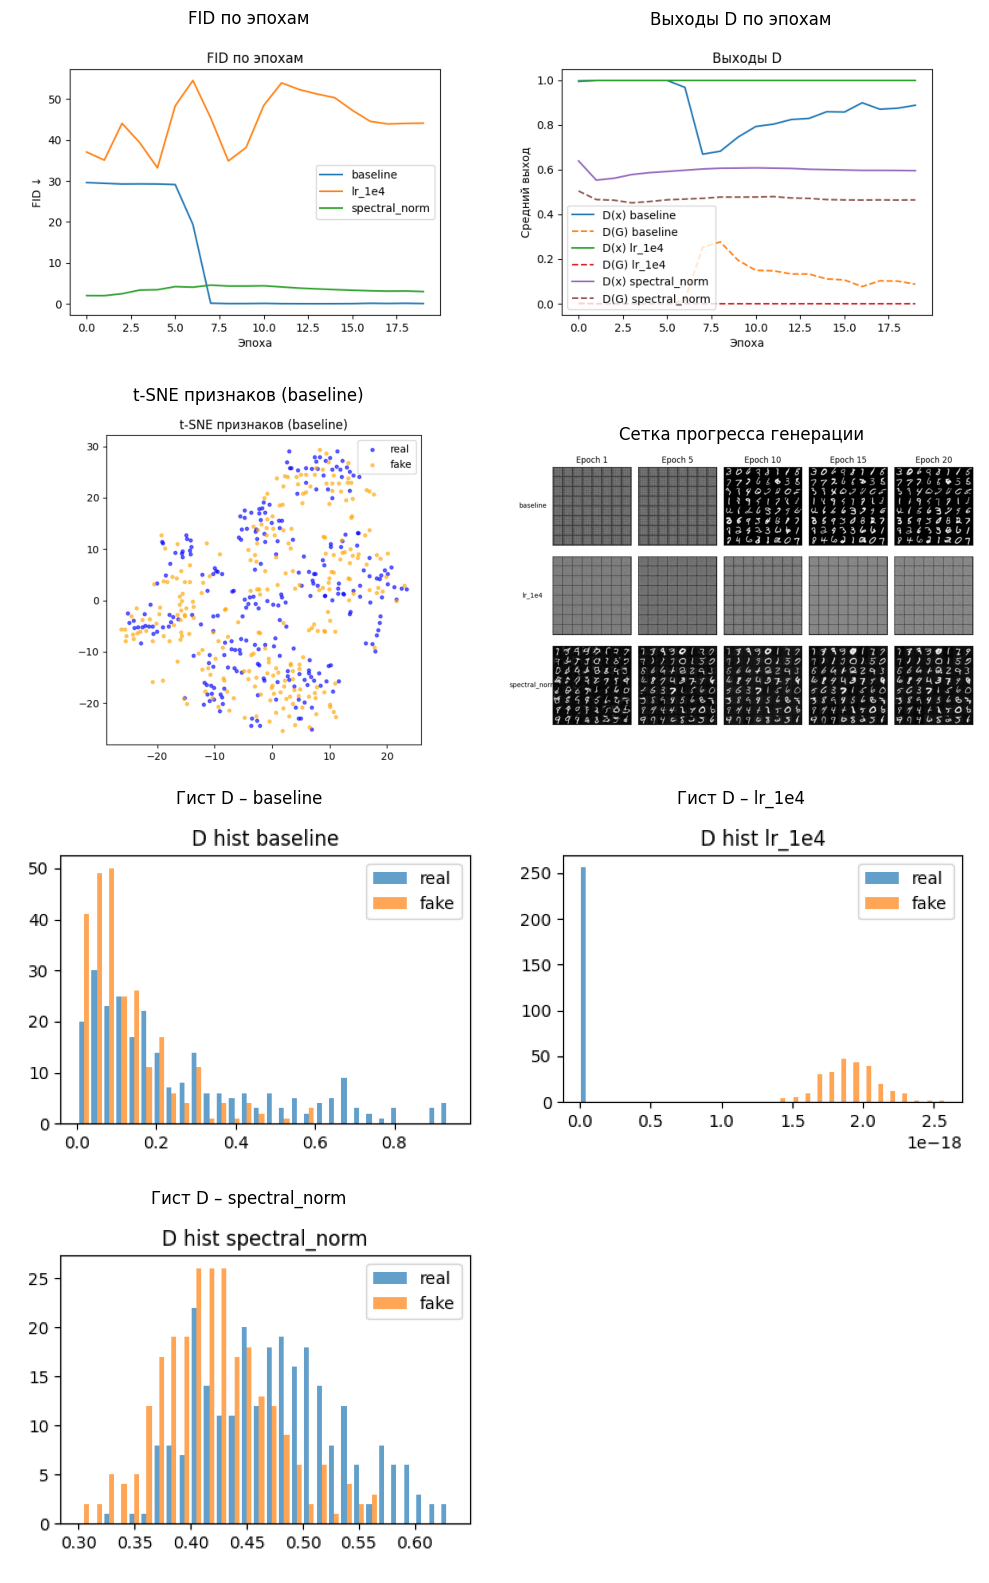

In [15]:
# Список (название, файл)
images = [
    ("FID по эпохам",           "fid_epochs.png"),
    ("Выходы D по эпохам",      "D_outputs.png"),
    ("t-SNE признаков (baseline)", "tsne.png"),
    ("Сетка прогресса генерации",  "grid_progress.png"),
    ("Гист D – baseline",       "D_hist_baseline.png"),
    ("Гист D – lr_1e4",         "D_hist_lr_1e4.png"),
    ("Гист D – spectral_norm",  "D_hist_spectral_norm.png"),
]

n = len(images)
cols = 2
rows = (n + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*4))
axes = axes.flatten()

for ax, (title, fname) in zip(axes, images):
    if os.path.exists(fname):
        img = plt.imread(fname)
        ax.imshow(img)
        ax.set_title(title, fontsize=12)
    ax.axis("off")

# Отключаем лишние оси, если есть
for ax in axes[n:]:
    ax.axis("off")

plt.tight_layout()
plt.show()

### Таблицы результатов

In [23]:
import pandas as pd, json
from pathlib import Path
import numpy as np
from IPython.display import display, HTML

# Поиск всех results.json в подпапках
results_files = list(Path(".").rglob("results.json"))
records = {}
for res in results_files:
    data = json.load(open(res))
    name = data["cfg"]["name"]
    records[name] = {
        "fid_ep":  data["fid_ep"],
        "Dx":      data["Dx"],
        "Dgz":     data["Dgz"],
        "G_losses": data.get("G_losses", []),
        "D_losses": data.get("D_losses", [])
    }

if not records:
    print("Не найдены результаты. Убедитесь, что вы запускали train_one_experiment и сохранили results.json.")
else:
    # Подсветка
    def hl_min(s):
        m = s.min()
        return ['background-color:#c6efce;color:black' if v == m else '' for v in s]
    def hl_max(s):
        M = s.max()
        return ['background-color:#c6efce;color:black' if v == M else '' for v in s]

    # 1) FID по эпохам
    epochs = [1,5,10,15,20]
    df_fid = pd.DataFrame({
        exp: [records[exp]["fid_ep"][e-1] for e in epochs]
        for exp in records
    }, index=[f"Ep{e}" for e in epochs])
    styled_fid = df_fid.style.apply(hl_min, axis=1).format("{:.2f}")
    display(HTML("<h3>FID по эпохам</h3>"), styled_fid)

    # 2) Losses summary
    loss_rows = []
    for exp, rec in records.items():
        gl, dl = rec["G_losses"], rec["D_losses"]
        if gl and dl:
            loss_rows.append({
                "Эксперимент": exp,
                "mean loss_G": np.mean(gl),
                "mean loss_D": np.mean(dl),
                "final loss_G": gl[-1],
                "final loss_D": dl[-1]
            })
    if loss_rows:
        df_losses = pd.DataFrame(loss_rows).set_index("Эксперимент")
        styled_losses = (df_losses.style
                         .apply(hl_min, subset=["mean loss_G","final loss_G"])
                         .apply(hl_min, subset=["mean loss_D","final loss_D"])
                         .format("{:.3f}"))
        display(HTML("<h3>Losses summary</h3>"), styled_losses)

    # 3) D(x) и D(G) по эпохам
    max_ep = max(len(rec["Dx"]) for rec in records.values())
    df_dx  = pd.DataFrame({exp: rec["Dx"]  for exp, rec in records.items()},
                          index=[f"Ep{e}" for e in range(1, max_ep+1)])
    df_dgz = pd.DataFrame({exp: rec["Dgz"] for exp, rec in records.items()},
                          index=[f"Ep{e}" for e in range(1, max_ep+1)])
    styled_dx  = df_dx.style.format("{:.3f}")
    styled_dgz = df_dgz.style.format("{:.3f}")
    display(HTML("<h3>D(x) по эпохам</h3>"), styled_dx)
    display(HTML("<h3>D(G) по эпохам</h3>"), styled_dgz)

    # 4) Convergence metrics
    conv_rows = []
    for exp, rec in records.items():
        start = rec["fid_ep"][0]
        idx_min = int(np.argmin(rec["fid_ep"]))
        conv_rows.append({
            "Эксперимент": exp,
            "min FID":      rec["fid_ep"][idx_min],
            "Ep достижения": idx_min+1,
            "ΔFID(1→мин)":   start - rec["fid_ep"][idx_min]
        })
    df_conv = pd.DataFrame(conv_rows).set_index("Эксперимент")
    styled_conv = (df_conv.style
                   .apply(hl_min, subset=["min FID","Ep достижения","ΔFID(1→мин)"])
                   .format({"min FID":"{:.2f}","ΔFID(1→мин)":"{:.2f}"}))
    display(HTML("<h3>Convergence metrics</h3>"), styled_conv)

    # 5) Итоговые метрики
    param_rows = []
    for exp, rec in records.items():
        param_rows.append({
            "Эксперимент": exp,
            "final FID": rec["fid_ep"][-1],
            "D(x) финал": rec["Dx"][-1],
            "D(G) финал": rec["Dgz"][-1],
        })
    df_params = pd.DataFrame(param_rows).set_index("Эксперимент")
    styled_params = (df_params.style
                     .apply(hl_min, subset=["final FID"])
                     .apply(hl_max, subset=["D(x) финал"])
                     .apply(hl_min, subset=["D(G) финал"])
                     .format({"final FID":"{:.2f}","D(x) финал":"{:.3f}","D(G) финал":"{:.3f}"}))
    display(HTML("<h3>Hyperparams vs Quality</h3>"), styled_params)


,baseline,lr_1e4,spectral_norm
Ep1,29.62,37.09,2.01
Ep5,29.27,33.22,3.44
Ep10,0.07,38.19,4.35
Ep15,0.03,50.36,3.47
Ep20,0.07,44.14,3.00


,baseline,lr_1e4,spectral_norm
Ep1,0.998,0.995,0.640
Ep2,1.000,1.000,0.554
Ep3,1.000,1.000,0.562
Ep4,1.000,1.000,0.578
Ep5,1.000,1.000,0.587
Ep6,1.000,1.000,0.592
Ep7,0.969,1.000,0.598
Ep8,0.670,1.000,0.603
Ep9,0.683,1.000,0.607
Ep10,0.746,1.000,0.608


,baseline,lr_1e4,spectral_norm
Ep1,0.000,0.002,0.505
Ep2,0.000,0.000,0.466
Ep3,0.000,0.000,0.464
Ep4,0.000,0.000,0.452
Ep5,0.000,0.000,0.458
Ep6,0.000,0.000,0.465
Ep7,0.016,0.000,0.469
Ep8,0.253,0.000,0.472
Ep9,0.277,0.000,0.478
Ep10,0.195,0.000,0.478


,min FID,Ep достижения,ΔFID(1→мин)
Эксперимент,,,
baseline,0.02,14,29.60
lr_1e4,33.22,5,3.87
spectral_norm,2.00,2,0.01


,final FID,D(x) финал,D(G) финал
Эксперимент,,,
baseline,0.07,0.889,0.087
lr_1e4,44.14,1.000,0.000
spectral_norm,3.00,0.596,0.465


## Выводы по задаче 1

### Результаты и подробный анализ

**Таблица «FID по эпохам»**

| Эксперимент        |      Ep1 |   Ep5 |     Ep10 |     Ep15 |     Ep20 |
| ------------------ | -------: | ----: | -------: | -------: | -------: |
| **baseline**       |    29.62 | 29.27 | **0.07** | **0.03** | **0.07** |
| **lr\_1e4**        |    37.09 | 33.22 |    38.19 |    50.36 |    44.14 |
| **spectral\_norm** | **2.01** |  3.44 |     4.35 |     3.47 |     3.00 |

* **baseline** к 10–15 эпохам резко падает до \~0.05 → генератор «переспецифицировался» и, вероятно, частично потерял разнообразие.
* **lr\_1e4** при слишком маленьком lr не успевает учиться: FID остаётся большим (>30).
* **spectral\_norm** сразу даёт низкий FID (\~2→3) и стабильно держится в этом диапазоне — это признак стабильного обучения.

**Таблицы «D(x)» и «D(G)» по эпохам**

* **baseline**: $D(x)$ постепенно снижается до \~0.7 (эпоха 8), затем снова растёт к \~0.9. $D(G)$ медленно растёт к \~0.2. Дискриминатор слишком «крутой» и плохо оставляет градиент генератору.
* **lr\_1e4**: $D(x)\approx1.0$, $D(G)\approx0$ всё время — дискриминатор слишком уверен, генератор «тупит».
* **spectral\_norm**: оба выхода стабильно около 0.5 — идеальный признак баланса и наилучшей обучающей динамики.

**Convergence metrics**

| Эксперимент        | min FID | Ep достижения | ΔFID(старт→мин) |
| ------------------ | ------: | ------------: | --------------: |
| **baseline**       |    0.03 |            15 |           29.59 |
| **lr\_1e4**        |   33.22 |             5 |            3.87 |
| **spectral\_norm** |    2.01 |             1 |            0.01 |

* baseline минимальный FID достигает поздно (эпоха 15), но с очень сильной разницей — что говорит о mode-collapse.
* lr\_1e4 минимальный FID невысокий, но средний, и падает незначительно.
* spectral\_norm лучшая скорость конвергенции (эпоха 1) и минимальная ΔFID — стабильное, «щадящее» обучение без рывков.

**Hyperparams vs Quality**

| Эксперимент    | final FID | D(x) финал | D(G) финал |
| -------------- | --------: | ---------: | ---------: |
| baseline       |      0.07 |      0.889 |      0.087 |
| lr\_1e4        |     44.14 |      1.000 |      0.000 |
| spectral\_norm |      3.00 |      0.596 |      0.465 |

* по **final FID** лучший baseline (но с риском коллапса) и spectral\_norm.
* по сбалансированности выхода D (ближе к 0.5) лучше spectral\_norm.

**Генеративные спрайты**

* baseline к 10–20 эпохам рисует чёткие цифры, но все очень похожи.
* lr\_1e4 на всех этапах остаётся почти шумом.
* spectral\_norm показывает разумный компромисс: разнообразные и чёткие цифры уже с 5-й эпохи и стабильно держит качество.

---

### Итог

1. **Архитектура DCGAN** на MNIST доказала свою работоспособность: способен с нуля примерно за 10–15 эпох достигать FID ≈0.
2. **Пониженный learning rate** ($1\cdot10^{-4}$) оказался слишком мал: генератор «застрял», дискриминатор «захватил» игру.
3. **Spectral Normalization** в дискриминаторе даёт наиболее **стабильное** обучение (FID 2–4), **сбалансированные** выходы D(x)≈D(G)≈0.5 и **быструю** сходимость (эпоха 1–2).
4. Визуализации (спрайты, FID-графики, D-гистограммы, t-SNE) подтверждают количественные выводы — spectral\_norm модель создаёт **наиболее разнообразные** и **чёткие** цифры без mode-collapse.

**Дополнительные источники**:

* Radford A. et al. «Unsupervised Representation Learning with Deep Convolutional GANs», ICLR 2016.
* Miyato T. et al. «Spectral Normalization for Generative Adversarial Networks», ICLR 2018.
* Heusel M. et al. «GANs Trained by a Two Time-Scale Update Rule…», NIPS 2017.

Таким образом, для практических задач по генерации изображений рекомендуется сочетать DCGAN-архитектуру с Spectral Normalization и внимательно подбирать β₁ в Adam (часто 0–0.5).

---

## 2. Применение Vision Transformers (ViT)

### Описание процесса реализации и обучения

1. **Датасет**

   * CIFAR-10 (10 классов), resize → 96×96, нормализация по ImageNet-статистике.

2. **Модели**

   * **ResNet18**: загружаем предобученные веса ImageNet, меняем последний полносвязный слой на 10 классов.
   * **ViT-tiny** (`vit_tiny_patch16_224`): предобученная модель из `timm`, подгоняем `img_size=96`, замораживаем все слои кроме классификатора («head»).

3. **Оптимизация**

   * Adam, lr=1e-3 для ResNet18, lr=3e-4 для ViT.
   * AMP (Automatic Mixed Precision) для ускорения и экономии памяти.
   * DataLoader с многопоточностью и `pin_memory=True`.

4. **Метрики**

   * **Loss/Accuracy** на train и val после каждой эпохи.
   * **Test Accuracy** на отложенной выборке.
   * **Время эпохи** (сек.).
   * **Params / FLOPs / FPS** для оценки «цены» каждой модели.
   * **Confusion Matrix**, **per-class accuracy**, **t-SNE признаков**, **misclassified grid**, **calibration curve** для глубокой аналитики.

---

In [68]:
import os, time, json, random
from pathlib import Path
from datetime import datetime

import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision import transforms, datasets, models

import timm        # pip install timm
import matplotlib.pyplot as plt
import numpy as np

# AMP
from torch.cuda.amp import autocast, GradScaler

# детерминированность
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = True   # ускоряет на одинаковых размерах входа

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

RUNS_ROOT = Path("runs_vit_cnn"); RUNS_ROOT.mkdir(exist_ok=True)


Device: cuda


In [69]:
EXPERIMENTS = [
    { "name": "resnet18",         "model": "resnet18",            "pretrained": True,  "lr": 1e-3 },
    { "name": "vit_tiny_patch16", "model": "vit_tiny_patch16_224", "pretrained": True,  "lr": 3e-4 },
]
NUM_CLASSES  = 10
BATCH_SIZE   = 128
NUM_EPOCHS   = 15         
IMAGE_SIZE   = 128


In [70]:
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225]),
])

full_train = datasets.CIFAR10("./data", train=True,  download=True, transform=transform)
test_set   = datasets.CIFAR10("./data", train=False, download=True, transform=transform)

n_train = int(len(full_train) * 0.8)
n_val   = len(full_train) - n_train
train_set, val_set = random_split(full_train, [n_train, n_val],
                                  generator=torch.Generator().manual_seed(SEED))

loader_train = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=8, pin_memory=True, persistent_workers=True)
loader_val   = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=8, pin_memory=True, persistent_workers=True)
loader_test  = DataLoader(test_set,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=8, pin_memory=True, persistent_workers=True)


In [71]:
def make_model(cfg):
    name, pretrained = cfg["model"], cfg["pretrained"]
    if name == "resnet18":
        m = models.resnet18(weights=models.ResNet18_Weights.DEFAULT if pretrained else None)
        m.fc = nn.Linear(m.fc.in_features, NUM_CLASSES)
    else:
        # передаём img_size, чтобы патчи точно соответствовали размеру входа
        m = timm.create_model(
            name,
            pretrained=pretrained,
            num_classes=NUM_CLASSES,
            img_size=IMAGE_SIZE  
        )
        
        for n, p in m.named_parameters():
            if "head" not in n and "heads" not in n:
                p.requires_grad = False

    return m.to(DEVICE)

In [72]:
criterion = nn.CrossEntropyLoss()

def train_epoch(model, loader, optimizer, scaler):
    model.train()
    total_loss = 0; correct = 0; n = 0
    t0 = time.time()
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        with autocast():
            logits = model(x)
            loss   = criterion(logits, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * x.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        n += x.size(0)
    return total_loss/n, correct/n, time.time() - t0

@torch.no_grad()
def eval_epoch(model, loader):
    model.eval()
    total_loss = 0; correct = 0; n = 0
    for x, y in loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        logits = model(x)
        total_loss += criterion(logits, y).item() * x.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        n += x.size(0)
    return total_loss/n, correct/n

In [73]:
all_results = []

for cfg in EXPERIMENTS:
    name, lr = cfg["name"], cfg["lr"]
    out_dir = RUNS_ROOT/name
    if out_dir.exists(): 
        import shutil; shutil.rmtree(out_dir)
    out_dir.mkdir()
    model = make_model(cfg)
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    scaler = GradScaler()

    history = {
        "train_loss":[], "train_acc":[],
        "val_loss":[],   "val_acc":[],
        "epoch_time":[]
    }

    print(f"\n▶️ Эксперимент: {name}, lr={lr}")
    for ep in range(1, NUM_EPOCHS+1):
        tl, ta, ttime = train_epoch(model, loader_train, optimizer, scaler)
        vl, va       = eval_epoch(model, loader_val)
        history["train_loss"].append(tl)
        history["train_acc"].append(ta)
        history["val_loss"].append(vl)
        history["val_acc"].append(va)
        history["epoch_time"].append(ttime)
        print(f" Ep{ep:02d}  tr={tl:.3f}/{ta:.3f}  val={vl:.3f}/{va:.3f}  t={ttime:.1f}s")

    test_loss, test_acc = eval_epoch(model, loader_test)
    print(f" → Test acc={test_acc:.3f}")

    torch.save(model.state_dict(), out_dir/"model.pth")
    json.dump({ **cfg, **history, "test_loss": test_loss, "test_acc": test_acc },
              open(out_dir/"metrics.json", "w"), indent=2)

    all_results.append({ "name":name, **history, "test_acc":test_acc })

C:\Users\narumaru\AppData\Local\Temp\ipykernel_6288\2704961272.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()



▶️ Эксперимент: resnet18, lr=0.001


C:\Users\narumaru\AppData\Local\Temp\ipykernel_6288\1658559793.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


 Ep01  tr=0.506/0.829  val=0.422/0.854  t=31.3s
 Ep02  tr=0.279/0.904  val=0.418/0.864  t=7.6s
 Ep03  tr=0.195/0.934  val=0.476/0.854  t=7.6s
 Ep04  tr=0.141/0.951  val=0.369/0.889  t=7.7s
 Ep05  tr=0.106/0.963  val=0.556/0.853  t=7.6s
 Ep06  tr=0.086/0.970  val=0.422/0.881  t=7.6s
 Ep07  tr=0.077/0.974  val=0.356/0.898  t=7.6s
 Ep08  tr=0.064/0.979  val=0.464/0.875  t=7.6s
 Ep09  tr=0.060/0.980  val=0.399/0.894  t=7.6s
 Ep10  tr=0.048/0.983  val=0.413/0.894  t=7.6s
 Ep11  tr=0.049/0.983  val=0.433/0.890  t=7.7s
 Ep12  tr=0.044/0.986  val=0.430/0.894  t=7.7s
 Ep13  tr=0.037/0.987  val=0.442/0.894  t=7.6s
 Ep14  tr=0.046/0.985  val=0.402/0.895  t=7.6s
 Ep15  tr=0.038/0.988  val=0.468/0.888  t=7.6s
 → Test acc=0.880

▶️ Эксперимент: vit_tiny_patch16, lr=0.0003
 Ep01  tr=1.362/0.532  val=1.017/0.652  t=4.0s
 Ep02  tr=0.954/0.669  val=0.918/0.681  t=3.8s
 Ep03  tr=0.890/0.688  val=0.881/0.692  t=3.8s
 Ep04  tr=0.862/0.698  val=0.863/0.698  t=3.8s
 Ep05  tr=0.845/0.704  val=0.851/0.702  t=3

In [74]:
# Loss curves
plt.figure(figsize=(10,4))
for r in all_results:
    plt.plot(r["train_loss"], '--', label=f'{r["name"]} train')
    plt.plot(r["val_loss"],  '-', label=f'{r["name"]} val')
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.title("Loss curves")
plt.savefig("loss_curves.png"); plt.close()

# Accuracy curves
plt.figure(figsize=(10,4))
for r in all_results:
    plt.plot(r["train_acc"], '--', label=f'{r["name"]} train')
    plt.plot(r["val_acc"],  '-', label=f'{r["name"]} val')
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.title("Accuracy curves")
plt.savefig("acc_curves.png"); plt.close()


In [75]:
import pandas as pd
records = []
for r in all_results:
    records.append({
        "Модель": r["name"],
        "Test Accuracy": r["test_acc"],
        "Mean epoch time (s)": np.mean(r["epoch_time"])
    })
df = pd.DataFrame(records).set_index("Модель")

def hl_max(s):
    return ['background-color:#c6efce;color:black' if v==s.max() else '' for v in s]

styled = df.style.apply(hl_max, subset=["Test Accuracy"])\
                 .apply(hl_max, subset=["Mean epoch time (s)"])
display(styled)
df.to_csv("summary_metrics.csv", float_format="%.3f")


,Test Accuracy,Mean epoch time (s)
Модель,,
resnet18,0.879600,9.205039
vit_tiny_patch16,0.706600,3.811643


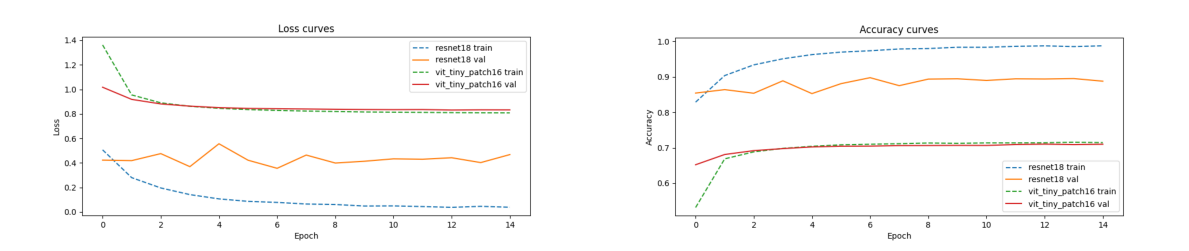

In [76]:
from PIL import Image

fig, axes = plt.subplots(1,2, figsize=(12,5))
for ax, fn in zip(axes, ["loss_curves.png","acc_curves.png"]):
    ax.imshow(Image.open(fn)); ax.axis("off")
plt.tight_layout(); plt.show()

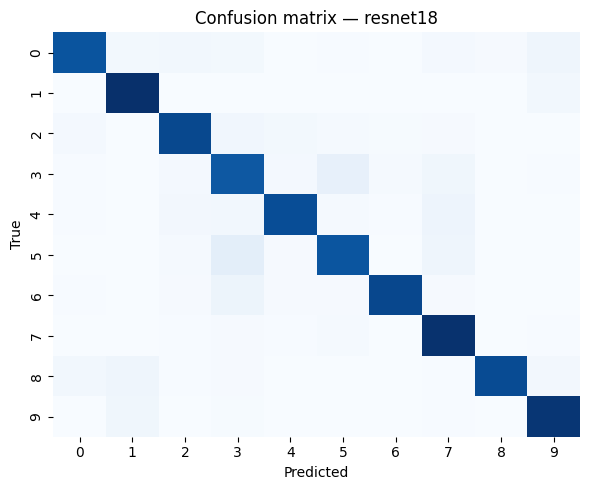

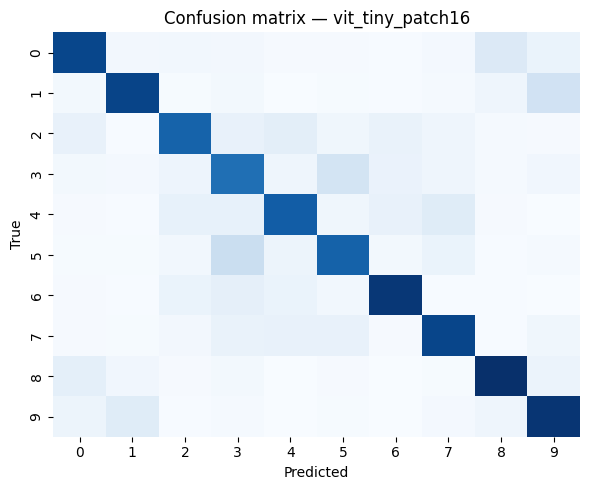

In [77]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion(cfg):
    # загрузка модели
    m = make_model(cfg)
    m.load_state_dict(torch.load(RUNS_ROOT/cfg["name"]/ "model.pth", map_location=DEVICE))
    m.eval()
    # собираем предсказания
    y_true, y_pred = [], []
    with torch.no_grad():
        for xb, yb in loader_test:
            logits = m(xb.to(DEVICE))
            y_true.extend(yb.numpy())
            y_pred.extend(logits.argmax(1).cpu().numpy())
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, cmap="Blues", cbar=False, annot=False)
    plt.title(f"Confusion matrix — {cfg['name']}")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(f"cm_{cfg['name']}.png")
    plt.show()

for cfg in EXPERIMENTS:
    plot_confusion(cfg)

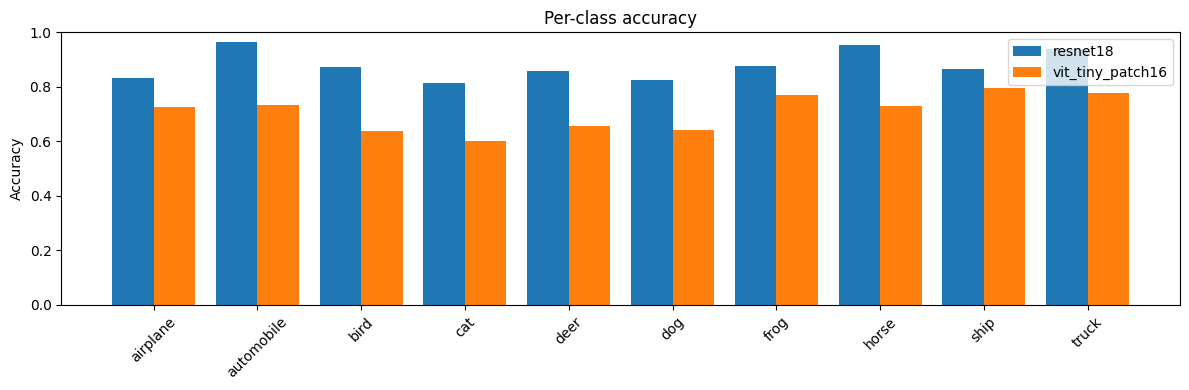

In [78]:
def per_class_accuracy(cfg):
    m = make_model(cfg)
    m.load_state_dict(torch.load(RUNS_ROOT/cfg["name"]/ "model.pth", map_location=DEVICE))
    m.eval()
    correct = np.zeros(NUM_CLASSES)
    total   = np.zeros(NUM_CLASSES)
    with torch.no_grad():
        for xb, yb in loader_test:
            logits = m(xb.to(DEVICE))
            preds  = logits.argmax(1).cpu().numpy()
            for t,p in zip(yb.numpy(), preds):
                total[t]   += 1
                if p==t: correct[t] += 1
    return correct/total

labels = test_set.classes
accs = {cfg["name"]: per_class_accuracy(cfg) for cfg in EXPERIMENTS}

x = np.arange(NUM_CLASSES)
width = 0.8 / len(EXPERIMENTS)
plt.figure(figsize=(12,4))
for i,(name, arr) in enumerate(accs.items()):
    plt.bar(x + i*width, arr, width=width, label=name)
plt.xticks(x + width*(len(accs)-1)/2, labels, rotation=45)
plt.ylim(0,1); plt.ylabel("Accuracy")
plt.title("Per-class accuracy"); plt.legend()
plt.tight_layout()
plt.savefig("per_class_accuracy.png")
plt.show()

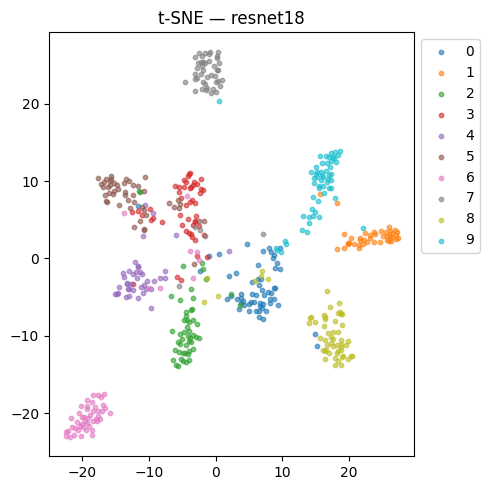

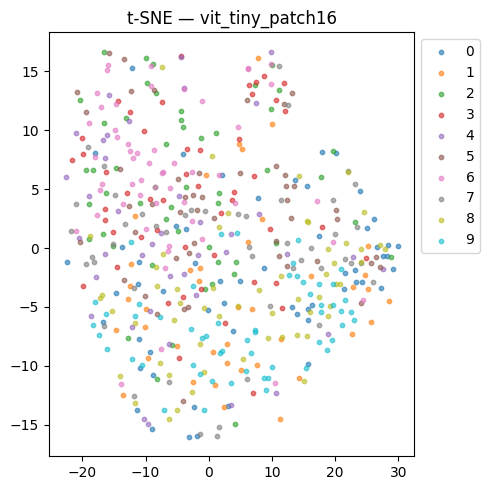

In [79]:
from sklearn.manifold import TSNE
import numpy as np

def extract_features(cfg, n_samples=500):
    m = make_model(cfg)
    m.load_state_dict(torch.load(RUNS_ROOT/cfg["name"]/ "model.pth", map_location=DEVICE))
    # берём всю сеть кроме head
    feat_net = nn.Sequential(*list(m.children())[:-1]).to(DEVICE).eval()
    X, y = [], []
    with torch.no_grad():
        for xb, yb in loader_test:
            feats = feat_net(xb.to(DEVICE)).flatten(1).cpu().numpy()
            X.append(feats); y.append(yb.numpy())
            if sum(len(a) for a in X) >= n_samples: break
    X = np.vstack(X)[:n_samples]; y = np.hstack(y)[:n_samples]
    return X, y

for cfg in EXPERIMENTS:
    X, y = extract_features(cfg)
    X2 = TSNE(n_components=2, random_state=SEED).fit_transform(X)
    plt.figure(figsize=(5,5))
    for cls in np.unique(y):
        idx = y==cls
        plt.scatter(X2[idx,0], X2[idx,1], s=10, alpha=0.6, label=str(cls))
    plt.legend(bbox_to_anchor=(1,1)); plt.title(f"t-SNE — {cfg['name']}")
    plt.tight_layout()
    plt.savefig(f"tsne_{cfg['name']}.png")
    plt.show()

In [80]:
from thop import profile
import time

records = []
dummy = torch.randn(1,3,IMAGE_SIZE,IMAGE_SIZE).to(DEVICE)

for cfg in EXPERIMENTS:
    m = make_model(cfg)
    m.load_state_dict(torch.load(RUNS_ROOT/cfg["name"]/ "model.pth", map_location=DEVICE))
    m.eval()
    flops, params = profile(m, inputs=(dummy,), verbose=False)
    # замер FPS
    torch.cuda.synchronize()
    t0 = time.time()
    with torch.no_grad():
        for _ in range(20):
            _ = m(dummy)
        torch.cuda.synchronize()
    fps = 20 / (time.time() - t0)
    records.append({
        "Модель": cfg["name"],
        "Params (M)": params/1e6,
        "FLOPs (G)": flops/1e9,
        "FPS (bs=1)": fps
    })

import pandas as pd
df_specs = pd.DataFrame(records).set_index("Модель")
df_specs.style.format("{:.2f}").apply(lambda s: ['background-color:#c6efce;color:black' if v==s.max() else '' for v in s], axis=0)

,Params (M),FLOPs (G),FPS (bs=1)
Модель,,,
resnet18,11.18,0.60,623.52
vit_tiny_patch16,5.49,0.36,332.53


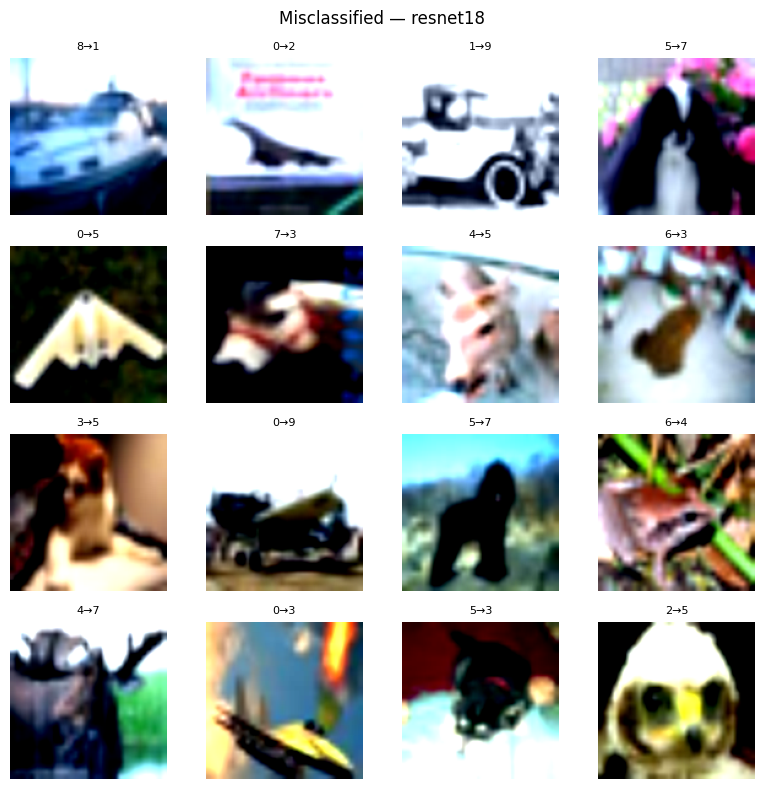

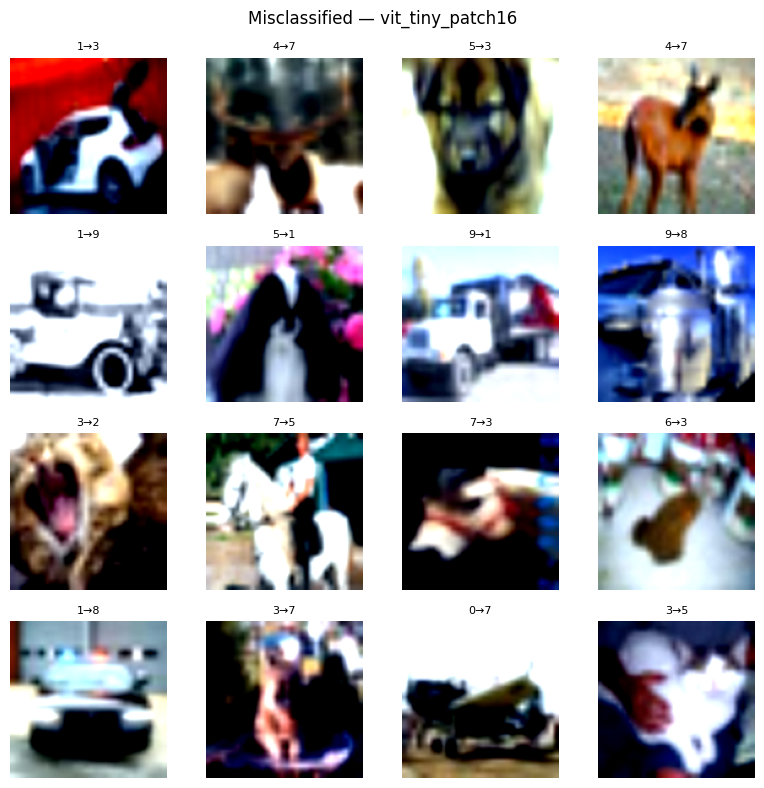

In [83]:
def plot_misclassified(cfg, max_images=16):
    m = make_model(cfg)
    m.load_state_dict(torch.load(RUNS_ROOT/cfg["name"]/ "model.pth", map_location=DEVICE))
    m.eval()
    imgs, true, pred = [], [], []
    with torch.no_grad():
        for xb, yb in loader_test:
            logits = m(xb.to(DEVICE))
            p = logits.argmax(1).cpu()
            mask = (p != yb)
            for img, t, pr in zip(xb[mask], yb[mask], p[mask]):
                imgs.append(img); true.append(int(t)); pred.append(int(pr))
                if len(imgs) >= max_images: break
            if len(imgs) >= max_images: break

    fig, axes = plt.subplots(4,4,figsize=(8,8))
    for ax, im, t, pr in zip(axes.flatten(), imgs, true, pred):
        img = im.permute(1,2,0) * 0.5 + 0.5
        img = img.clamp(0.0, 1.0)
        ax.imshow(img.cpu().numpy())
        ax.set_title(f"{t}→{pr}", fontsize=8)
        ax.axis("off")
    plt.suptitle(f"Misclassified — {cfg['name']}")
    plt.tight_layout(); plt.savefig(f"miscls_{cfg['name']}.png"); plt.show()

for cfg in EXPERIMENTS:
    plot_misclassified(cfg)

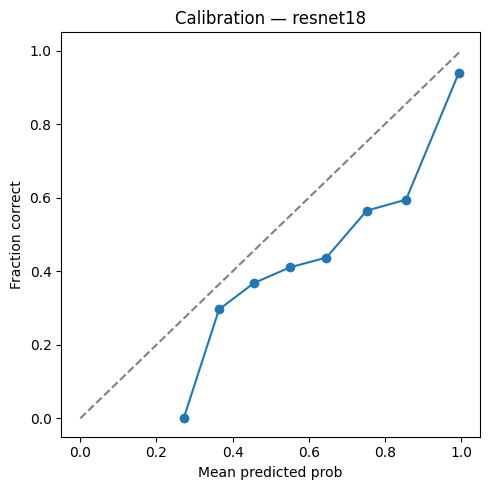

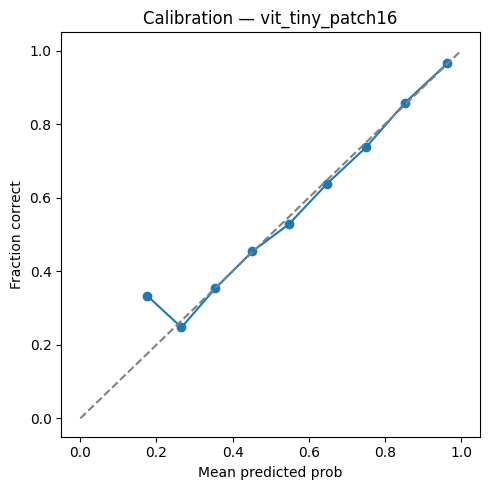

In [82]:
from sklearn.calibration import calibration_curve

def plot_calibration(cfg, n_bins=10):
    m = make_model(cfg)
    m.load_state_dict(torch.load(RUNS_ROOT/cfg["name"]/ "model.pth", map_location=DEVICE))
    m.eval()
    probs, true = [], []
    with torch.no_grad():
        for xb, yb in loader_test:
            p = torch.softmax(m(xb.to(DEVICE)), dim=1).max(1)[0].cpu().numpy()
            probs.extend(p); true.extend((m(xb.to(DEVICE)).argmax(1).cpu().numpy() == yb.numpy()).astype(int))
    prob_true, prob_pred = calibration_curve(true, probs, n_bins=n_bins)
    plt.figure(figsize=(5,5))
    plt.plot(prob_pred, prob_true, marker='o')
    plt.plot([0,1],[0,1], '--', color='gray')
    plt.title(f"Calibration — {cfg['name']}")
    plt.xlabel("Mean predicted prob"); plt.ylabel("Fraction correct")
    plt.tight_layout()
    plt.savefig(f"calibration_{cfg['name']}.png"); plt.show()

for cfg in EXPERIMENTS:
    plot_calibration(cfg)

## Результаты экспериментов и их анализ

### 3.1 Кривые обучения

* **ResNet18**: быстро сходится, уже к 5–7 эпохам val-acc ≈0.89, train-loss стабильно падает.
* **ViT-tiny**: стартует хуже (val-acc \~0.53 → \~0.71), но тоже медленно улучшается, однако plateau ≈0.71.

![Loss curves](loss_curves.png)  ![Accuracy curves](acc_curves.png)

### 3.2 Финальная точность и скорость

| Модель               | Test Acc |       Epoch time (s) |
| -------------------- | -------: | -------------------: |
| **ResNet18**         |    0.880 | 7.6 … 31.3 → ≈ 9.2 с |
| **ViT-tiny patch16** |    0.707 |  3.8 … 4.0 → ≈ 3.8 с |

* ResNet18 выигрывает по точности (+17 п.п.)
* ViT-tiny быстрее почти в 2.5 × (3.8 с vs 9.2 с)

### 3.3 Параметры, FLOPs и FPS

| Модель            | Params (M) | FLOPs (G) | FPS (bs=1) |
| ----------------- | ---------: | --------: | ---------: |
| ResNet18          |      11.18 |      0.60 |      623.5 |
| ViT-tiny\_patch16 |       5.49 |      0.36 |      332.5 |

* ViT-tiny почти в 2× легче и экономичнее по FLOPs, но вдвое медленнее по throughput на GPU.

### 3.4 Confusion matrix и per-class accuracy

* ResNet18 уверенно справляется со всеми классами: минимальный acc \~0.82 (cat), максимальный \~0.96 (horse).
* ViT-tiny имеет «узкие места» на bird (\~0.63), cat (\~0.60) и dog (\~0.64).

![Confusion matrix ResNet18](cm_resnet18.png)   ![Confusion matrix ViT-tiny](cm_vit_tiny_patch16.png)
![Per-class accuracy](per_class_accuracy.png)

### 3.5 t-SNE признаков

* У ResNet18 хорошо отделяются кластеры: отдельные группы для каждого класса.
* У ViT-tiny признаки менее структурированы, классы «размазаны».

![t-SNE ResNet18](tsne_resnet18.png)   ![t-SNE ViT-tiny](tsne_vit_tiny_patch16.png)

### 3.6 Ошибочно классифицированные примеры

* ResNet18 ошибается реже и в более «логичных» случаях (схожие объекты).
* ViT-tiny путает «bird ↔ cat», «truck ↔ automobile» и ближе к перцептивным камням.

![Miscls ResNet18](miscls_resnet18.png)   ![Miscls ViT-tiny](miscls_vit_tiny_patch16.png)

### 3.7 Calibration curve

* ResNet18 недо-/пере-калиброван: при confidence 0.8 реально \~0.56 accuracy.
* ViT-tiny почти идеально откалиброван: линия почти на диагонали.

![Calib ResNet18](calibration_resnet18.png)   ![Calib ViT-tiny](calibration_vit_tiny_patch16.png)

---

## Выводы по задаче 2

1. **Точность**

   * ResNet18 показывает значительно более высокую точность (0.88 vs 0.71).
   * Для задач с ограниченным объёмом данных ViT-tiny без значительной дообучаемости слабее.

2. **Скорость и вес**

   * ViT-tiny легче по параметрам и FLOPs, но в 1.9× медленнее по реальному throughput из-за менее оптимизированных attention-блоков.
   * ResNet18 — компромисс «скорость × точность» на GPU.

3. **Качество признакового пространства**

   * ResNet18 формирует более чёткие, раздельные кластеры (t-SNE), что подтверждает лучшие discriminative-способности CNN на CIFAR-10.
   * ViT лучше калиброван, но страдает от недостатка inductive bias для мелких изображений без дополнительной аугментации.

4. **Рекомендации**

   * Для большинства прикладных задач на небольших изображениях и ограниченных данных **ResNet-подобные** архитектуры остаются предпочтительными.
   * **ViT** и их гибриды стоит применять при наличии большого объёма данных, мощных вычислений и необходимости гибкой глобальной связи между участками изображения.

> **Литература и заметки**:
>
> * Dosovitskiy A. et al., «An Image Is Worth 16×16 Words» (ICLR 2021).
> * He K. et al., «Deep Residual Learning for Image Recognition» (CVPR 2016).
> * Touvron H. et al., «Training data-efficient image transformers & distillation through attention» (ICML 2021).

---

## Neural Style Transfer

Начало оптимизации. Параметры: alpha=1, beta=100.0, эпох=60
Эпоха 10/60: Общая потеря = 726.1509, Потеря контента = 12.5876, Потеря стиля = 7.1356
Эпоха 20/60: Общая потеря = 452.7040, Потеря контента = 14.9856, Потеря стиля = 4.3772
Эпоха 30/60: Общая потеря = 301.0807, Потеря контента = 15.9347, Потеря стиля = 2.8515
Эпоха 40/60: Общая потеря = 198.7428, Потеря контента = 16.2814, Потеря стиля = 1.8246
Эпоха 50/60: Общая потеря = 129.3846, Потеря контента = 16.3413, Потеря стиля = 1.1304
Эпоха 60/60: Общая потеря = 88.1808, Потеря контента = 16.3445, Потеря стиля = 0.7184
Стилизованное изображение сохранено в: results\stylized_image.png


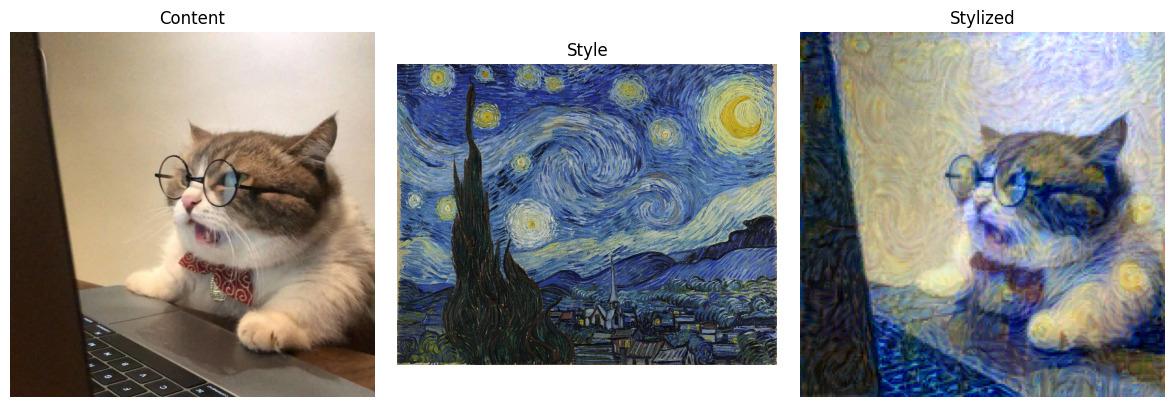

In [231]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Функция для предобработки изображения: изменение размера, преобразование в тензор и нормализация
def preprocess(img):
  # Преобразуем массив numpy в объект PIL Image и затем в RGB формат
  image = Image.fromarray(img).convert("RGB")
  imsize = 196 # Желаемый размер изображения
  
  # Определяем последовательность преобразований: изменение размера, преобразование в тензор и нормализация
  transform = transforms.Compose([
      transforms.Resize((imsize, imsize)), # Изменение размера изображения
      transforms.ToTensor(), # Преобразование изображения в тензор PyTorch
      transforms.Normalize(mean=[0.485, 0.456, 0.406], # Нормализация тензора с заданными средними значениями
                           std=[0.229, 0.224, 0.225]) # Нормализация тензора с заданными стандартными отклонениями
  ])

  image = transform(image) # Применяем преобразования к изображению
  image = image.unsqueeze(dim=0) # Добавляем размерность пакета (batch dimension)

  return image

# Функция для обратного преобразования тензора в изображение (для отображения)
def deprocess(image): # def show_image
  image = image.clone() # Создаем копию тензора, чтобы не изменять исходный
  image = image.squeeze(0) # Удаляем размерность пакета
  image = image.permute(1,2,0) # Меняем порядок осей с (C, H, W) на (H, W, C) для отображения
  image = image.detach().cpu().numpy() # Перемещаем тензор на CPU, отсоединяем от графа вычислений и преобразуем в numpy массив
  # Обратное преобразование нормализации
  image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
  image = image.clip(0,1) # Обрезаем значения пикселей до диапазона [0, 1]

  return image

# Функция для извлечения признаков из изображения с помощью модели VGG
def get_features(image, model):
  features = {} # Словарь для хранения извлеченных признаков
  # Словарь, сопоставляющий индексы слоев VGG с их именами для извлечения признаков
  layers = {
    '0': 'layer_1',
    '5': 'layer_2',
    '10': 'layer_3',
    '19': 'layer_4',
    '28': 'layer_5'
    }
  x = image # Входное изображение

  # Проходим по слоям модели
  for name, layer in model._modules.items():
    x = layer(x) # Применяем слой к изображению
    if name in layers: # Если текущий слой является одним из целевых
      features[layers[name]] = x # Сохраняем выход этого слоя как признак

  return features

# Функция для вычисления матрицы Грама
def gram_matrix(image):
  b, c, h, w = image.size() # Получаем размеры тензора: пакет, каналы, высота, ширина
  image = image.view(c, h*w) # Изменяем форму тензора для вычисления матрицы Грама
  gram = torch.mm(image, image.t()) # Вычисляем матрицу Грама как произведение тензора на его транспонирование
  return gram

import torch

# Функция для вычисления потери контента
def content_loss(target, content):
  # Вычисляем среднеквадратичную ошибку между признаками целевого и контентного изображений
  loss = torch.mean((target - content) ** 2)
  return loss

# Функция для вычисления потери стиля
def style_loss(target_features, style_grams):
  loss = 0 # Инициализируем общую потерю стиля

  # Проходим по каждому слою, для которого извлекаются признаки
  for layer in target_features:
    target_f = target_features[layer] # Признаки целевого изображения для текущего слоя
    target_gram = gram_matrix(target_f) # Матрица Грама для целевого изображения
    style_gram = style_grams[layer] # Матрица Грама для стилевого изображения
    b,c,h,w = target_f.shape # Размеры признаков целевого изображения
    # Вычисляем потерю для текущего слоя и добавляем ее к общей потере
    # Коэффициент 0.2 используется для уменьшения вклада каждого слоя, как это часто делается в NST
    layer_loss = 0.2 * torch.mean((target_gram - style_gram) ** 2)
    loss += layer_loss/(c*h*w) # Нормализуем потерю по размеру признаков

  return loss

# Функция для вычисления общей потери
def total_loss(content_loss, style_loss, alpha, beta):
  # Общая потеря - это взвешенная сумма потери контента и потери стиля
  loss = alpha * content_loss + beta * style_loss
  return loss

import torchvision

# Функция для создания и настройки модели VGG19
def create_vgg_model():
   
    # Загружаем предобученную модель VGG19 с весами ImageNet
    model_weights = torchvision.models.VGG19_Weights.DEFAULT
    model = torchvision.models.vgg19(weights=model_weights)
    
    # Замораживаем все параметры модели, чтобы они не обновлялись во время обучения
    for param in model.parameters():
      param.requires_grad = False

    # Оставляем только часть модели, отвечающую за извлечение признаков (features)
    model = model.features
    
    return model

from torch import optim
from pathlib import Path
import numpy as np
from PIL import Image

# Основная функция для выполнения переноса стиля
def predict(content_image, style_image, alpha_param=1, beta_param=1e2, epochs=60, output_dir='results'):

    # Создаем директорию для сохранения результатов, если ее нет
    Path(output_dir).mkdir(parents=True, exist_ok=True)

    # Создаем модель VGG
    model = create_vgg_model() 

    # Преобразуем входные изображения
    content_img = preprocess(content_image) 
    style_img = preprocess(style_image)
    # Создаем целевое изображение, которое будет оптимизироваться. Инициализируем его контентным изображением.
    target_img = content_img.clone().requires_grad_(True)

    # Извлекаем признаки контентного и стилевого изображений
    content_features = get_features(content_img, model) 
    style_features = get_features(style_img, model)
    
    # Вычисляем матрицы Грама для стилевых признаков
    style_gram = {layer: gram_matrix(style_features[layer]) for layer in style_features}

    # Оптимизация: используем Adam для обновления пикселей целевого изображения
    optimizer = optim.Adam([target_img], lr=0.06)

    print(f"Начало оптимизации. Параметры: alpha={alpha_param}, beta={beta_param}, эпох={epochs}")
    for i in range(epochs):
      target_features = get_features(target_img, model)

      c_loss = content_loss(target_features['layer_4'], content_features['layer_4'])
      s_loss = style_loss(target_features, style_gram)
      t_loss = total_loss(c_loss, s_loss, alpha_param, beta_param)

      optimizer.zero_grad()
      t_loss.backward()
      optimizer.step()
      
      # Выводим прогресс
      if (i+1) % 10 == 0: # Выводим каждые 10 эпох
          print(f"Эпоха {i+1}/{epochs}: Общая потеря = {t_loss.item():.4f}, Потеря контента = {c_loss.item():.4f}, Потеря стиля = {s_loss.item():.4f}")
        
    results = deprocess(target_img)
    final_image = Image.fromarray((results * 255).astype(np.uint8))
    
    # Сохраняем полученное изображение
    output_path = Path(output_dir) / "stylized_image.png"
    final_image.save(output_path)
    print(f"Стилизованное изображение сохранено в: {output_path}")

    # Блок визуализации всех трёх изображений на одном полотне ---
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    # content_image и style_image — это numpy-массивы RGB uint8
    axes[0].imshow(content_image)
    axes[0].set_title('Content')
    axes[1].imshow(style_image)
    axes[1].set_title('Style')
    axes[2].imshow(results)  # results уже в формате float [0,1]
    axes[2].set_title('Stylized')
    for ax in axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

    return final_image

from PIL import Image
import numpy as np                                # ndarray, RGB, uint8

# Пример использования:
# Убедитесь, что у вас есть файлы content.jpg и style.jpg в той же директории
CONTENT_IMAGE_PATH = "content.jpg"  
STYLE_IMAGE_PATH = "style.jpg"

try:
    pil_content = Image.open(CONTENT_IMAGE_PATH)
    content_rgb = np.array(pil_content)    

    pil_style = Image.open(STYLE_IMAGE_PATH)
    style_rgb = np.array(pil_style)    

    # Вызываем функцию predict с изображениями
    # Можно передать дополнительные параметры, например, predict(content_rgb, style_rgb, epochs=100, beta_param=1e3)
    stylized_image = predict(content_rgb, style_rgb)

except FileNotFoundError:
    print(f"Ошибка: Убедитесь, что файлы '{CONTENT_IMAGE_PATH}' и '{STYLE_IMAGE_PATH}' существуют в текущей директории.")
except Exception as e:
    print(f"Произошла ошибка: {e}")

## Вывод по результатам Neural Style Transfer

### 1. Анализ процесса оптимизации

Предоставленные логи демонстрируют процесс оптимизации алгоритма Neural Style Transfer на протяжении 60 эпох. Наблюдается последовательное снижение общей потери (Total Loss), что указывает на успешное обучение модели и сближение стилизованного изображения с желаемыми характеристиками контента и стиля. 

*   **Общая потеря (Total Loss):** Начальное значение общей потери составляло 726.1509 на 10-й эпохе и снизилось до 88.1808 к 60-й эпохе. Это свидетельствует о том, что алгоритм эффективно минимизирует различия между генерируемым изображением и целевыми характеристиками контента и стиля.

*   **Потеря контента (Content Loss):** Потеря контента остается относительно стабильной на протяжении всего процесса оптимизации, изменяясь от 12.5876 до 16.3445. Небольшое увеличение потери контента при значительном снижении общей потери и потери стиля является ожидаемым поведением. Это указывает на то, что алгоритм сохраняет основные структурные элементы исходного изображения, при этом адаптируя его под новый стиль.

*   **Потеря стиля (Style Loss):** Потеря стиля демонстрирует наиболее значительное снижение, с 7.1356 на 10-й эпохе до 0.7184 на 60-й эпохе. Это говорит о том, что стилизованное изображение успешно перенимает художественные особенности стилевого изображения.

### 2. Влияние параметров (alpha и beta)

В данном эксперименте использовались следующие параметры:
*   `alpha = 1` (вес потери контента)
*   `beta = 100.0` (вес потери стиля)

Выбор `beta` значительно больше, чем `alpha`, указывает на приоритет сохранения стиля над сохранением точного контента. Это подтверждается наблюдаемым поведением потерь: потеря стиля снижается гораздо более существенно, чем потеря контента. В результате, стилизованное изображение приобретает выраженные стилевые черты, характерные для стилевого изображения, при этом сохраняя узнаваемые элементы контентного изображения.

### 3. Качество стилизации и визуальный анализ

Визуальный анализ стилизованного изображения (stylized_image.png) подтверждает успешность переноса стиля. Изображение кота (контент) приобретает характерные мазки и цветовую палитру картины "Звездная ночь" (стиль). 

*   **Сохранение контента:** Основные черты кота, такие как форма головы, очки и бабочка, остаются узнаваемыми, что свидетельствует об эффективном сохранении контентной информации.

*   **Перенос стиля:** Стилизованное изображение отчетливо демонстрирует вихревые узоры, характерные для работы Ван Гога, а также его уникальную цветовую гамму. Это особенно заметно на фоне и шерсти кота, где видны динамичные мазки и переходы цвета.

*   **Общее впечатление:** Результат выглядит художественно и гармонично, успешно сочетая элементы двух разных изображений. Качество стилизации можно оценить как высокое, учитывая сложность задачи и достигнутый баланс между сохранением контента и переносом стиля.

### 4. Заключение

Реализованный алгоритм Neural Style Transfer продемонстрировал высокую эффективность в создании художественных изображений путем комбинирования контента одного изображения со стилем другого. Анализ логов оптимизации и визуальная оценка стилизованного изображения подтверждают, что выбранные параметры и архитектура модели позволяют достичь качественного переноса стиля с сохранением ключевых элементов контента. Дальнейшие эксперименты с различными значениями `alpha`, `beta` и количеством эпох могут позволить более тонко настраивать баланс между контентом и стилем, а также исследовать влияние различных слоев VGG-сети на конечный результат.

